In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data
from qe_model import *
from matplotlib import style
import scipy.stats as stats
import statsmodels.api as sm
import math
#from functions.find_bubbles import *
import matplotlib.transforms as mtransforms

In [4]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

In [5]:
style.use('seaborn-ticks')

# QE - QT experiments

In [6]:
params_nb = {"fundamental_value": 166,
             "trader_sample_size": 22,
             "n_traders": 1000,
             "ticks": 600,
             "std_fundamental": 0.053,
             "init_assets": 740,
             'spread_max': 0.004,
             'money_multiplier': 2.2,
             "horizon": 200,
             "std_noise": 0.049,
             "w_random": 0.08,
             "strat_share_chartists": 0.08,
             "base_risk_aversion": 1.051,
             "fundamentalist_horizon_multiplier": 3.8,
             "trades_per_tick": 1, "mutation_intensity": 0.0477,
             "average_learning_ability": 0.05,
             "bond_mean_reversion": 0.0, 'cb_pf_range': 0.05,
             "qe_perc_size": 0.16, "cb_size": 0.024, "qe_asset_index": 0, "qe_start": 0, "qe_end":0}

In [7]:
with open('estimated_params.json', 'r') as f:
    est_params = json.loads(f.read())

In [8]:
problem = {
  'num_vars': 7,
  'names': ['std_noise', "w_random", "strat_share_chartists",
            "base_risk_aversion", "fundamentalist_horizon_multiplier",
            "mutation_intensity", "average_learning_ability"],
  'bounds': [[0.03, 0.09], [0.02, 0.15], [0.02, 0.3],
            [0.05, 3.0], [1.0, 5.0],
            [0.05,0.5], [0.01, 0.8]]
}

In [9]:
for i, name in enumerate(problem['names']):
    params_nb[name] = est_params[i]

In [10]:
# 
params_nb['strat_share_chartists'] = 0.5

In [16]:
NRUNS = 3
burn_in_period = 0

In [17]:
#scenarios = [None, 'BLR', 'BUSTQE', 'BUSTQT', 'BOOMQE', 'BOOMQT']
#scenarios = ['BUSTQE']
scenarios = [None, 'BLR', 'BUSTQE', 'BOOMQT']

In [18]:
steps = 5
qe_size = [x / 100.0 for x in range(0, 100 + steps, steps)]
qe_size = qe_size[0:-12]
qe_size

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

In [19]:
experiments = len(qe_size)

In [20]:
full_qe_size = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_qe_size.append(qe_size[exp])

In [21]:
prices = []
fundamentals = []
volumes = []
qe_periods = []
qt_periods = []

for scenario in scenarios:
    for exp in range(experiments):
        params_nb['qe_perc_size'] = qe_size[exp]
        trdrs = []
        orbs = []
        central_banks = []
        
        for seed_nb in range(NRUNS): 
            traders_nb, central_bank_nb, orderbook_nb = init_objects(params_nb, seed_nb)
            traders_nb, central_bank_nb, orderbook_nb = qe_model(traders_nb, central_bank_nb, orderbook_nb, params_nb, scenario=scenario, seed=seed_nb)
            central_banks.append(central_bank_nb)
            trdrs.append(traders_nb)
            orbs.append(orderbook_nb)

        prices.append(pd.DataFrame([orbs[run].tick_close_price for run in range(NRUNS)]).transpose())
        fundamentals.append(pd.DataFrame([orbs[run].fundamental for run in range(NRUNS)]).transpose())
        volumes.append(pd.DataFrame([[sum(v) for v in orbs[run].transaction_volumes_history] for run in range(NRUNS)]).transpose())
        # bug here!!
        qe_periods.append(pd.DataFrame([[orbs[run].qe_period] for run in range(NRUNS)]).transpose())
        qt_periods.append(pd.DataFrame([[orbs[run].qt_period] for run in range(NRUNS)]).transpose())

Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
4

426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675


657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
Start of simulation  1
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
3

287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536


519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768


750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
Start of simulation  2
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
3

376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625


611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
2

238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487


cb QE
319
cb QE
320
cb QE
321
cb QE
322
cb QE
323
cb QE
324
cb QE
325
cb QE
326
cb QE
327
cb QE
328
cb QE
329
cb QE
330
cb QE
331
cb QE
332
cb QE
333
cb QE
334
cb QE
335
cb QE
336
cb QE
337
cb QE
338
cb QT
339
cb QT
340
cb QT
341
cb QT
342
cb QT
343
cb QT
344
cb QT
345
cb QT
346
cb QT
347
cb QT
348
cb QT
349
cb QT
350
cb QT
351
cb QT
352
cb QT
353
cb QT
354
cb QT
355
cb QT
356
cb QT
357
cb QT
358
cb QT
359
cb QT
360
cb QT
361
cb QT
362
cb QT
363
cb QT
364
cb QT
365
cb QT
366
cb QT
367
cb QT
368
cb QT
369
cb QT
370
cb QT
371
cb QT
372
cb QT
373
cb QT
374
cb QT
375
cb QT
376
cb QT
377
cb QT
378
cb QT
379
cb QT
380
cb QT
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
cb QT
418
cb QT
419
cb QT
420
cb QT
421
cb QT
422
cb QT
423
cb QT
424
cb QT
425
cb QT
426
cb QT
427
cb QT
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
cb QT
444
cb QT
445
cb QT
446
cb QT
447
cb QT
448
cb QT


311
cb QT
312
cb QT
313
cb QT
314
cb QT
315
cb QT
316
cb QT
317
cb QT
318
cb QT
319
cb QT
320
cb QT
321
cb QT
322
cb QT
323
cb QT
324
cb QT
325
cb QT
326
cb QT
327
cb QT
328
cb QT
329
cb QT
330
cb QT
331
cb QT
332
cb QT
333
cb QT
334
cb QT
335
cb QT
336
cb QT
337
cb QT
338
cb QT
339
cb QT
340
cb QT
341
cb QT
342
cb QT
343
cb QT
344
cb QT
345
cb QT
346
cb QT
347
cb QT
348
cb QT
349
cb QT
350
cb QT
351
cb QT
352
cb QT
353
cb QT
354
cb QT
355
cb QT
356
cb QT
357
cb QT
358
cb QT
359
cb QT
360
cb QT
361
cb QT
362
cb QT
363
cb QT
364
cb QT
365
cb QT
366
cb QT
367
cb QT
368
cb QT
369
cb QT
370
cb QT
371
cb QT
372
cb QT
373
cb QT
374
cb QT
375
cb QT
376
cb QT
377
cb QT
378
cb QT
379
cb QT
380
cb QT
381
cb QT
382
cb QT
383
cb QT
384
cb QT
385
cb QT
386
cb QT
387
cb QT
388
cb QT
389
cb QT
390
cb QT
391
cb QT
392
cb QT
393
cb QT
394
cb QT
395
cb QT
396
cb QT
397
cb QT
398
cb QT
399
cb QT
400
cb QT
401
cb QT
402
cb QT
403
cb QT
404
cb QT
405
cb QT
406
cb QT
407
cb QT
408
cb QT
409
cb QT
410
cb QT


cb QT
348
cb QT
349
cb QT
350
cb QT
351
cb QT
352
cb QT
353
cb QT
354
cb QT
355
cb QT
356
cb QT
357
cb QT
358
cb QT
359
cb QT
360
cb QT
361
cb QT
362
cb QT
363
cb QT
364
cb QT
365
366
cb QT
367
cb QT
368
cb QT
369
cb QT
370
cb QT
371
cb QT
372
cb QT
373
cb QT
374
cb QT
375
cb QT
376
cb QT
377
cb QT
378
cb QT
379
cb QT
380
cb QT
381
cb QT
382
383
384
cb QT
385
cb QT
386
cb QT
387
cb QT
388
cb QT
389
cb QT
390
cb QT
391
cb QT
392
cb QT
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
cb QE
427
cb QE
428
cb QE
429
cb QE
430
cb QE
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
cb Q

463
cb QT
464
cb QT
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
cb QT
481
cb QT
482
cb QT
483
cb QT
484
cb QT
485
cb QT
486
cb QT
487
cb QT
488
cb QT
489
cb QT
490
cb QT
491
cb QT
492
cb QT
493
cb QT
494
cb QT
495
cb QT
496
cb QT
497
cb QT
498
cb QT
499
cb QT
500
cb QT
501
cb QT
502
cb QT
503
cb QT
504
cb QT
505
cb QT
506
cb QT
507
cb QT
508
cb QT
509
cb QT
510
cb QT
511
cb QT
512
cb QT
513
cb QT
514
cb QT
515
cb QT
516
cb QT
517
cb QT
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
cb QE
573
cb QE
574
cb QE
575
cb QE
576
cb QE
577
cb QE
578
cb QE
579
cb QE
580
cb QE
581
cb QE
582
cb QE
583
cb QE
584
cb QE
585
cb QE
586
cb QE
587
cb QE
588
cb QE
589
cb QE
590
cb QE
591
cb QE
592
cb QE
593
cb QE
594
cb QE
595
cb QE
596
cb QE
597
cb QE
598
cb QE
599
600
cb QE
601
cb QE
602
cb QE
603
604
605
606
cb Q

774
cb QE
775
cb QE
776
cb QE
777
cb QE
778
cb QE
779
cb QE
780
cb QE
781
cb QE
782
cb QE
783
784
785
786
cb QE
787
cb QE
788
cb QE
789
cb QE
790
cb QE
791
cb QE
792
cb QE
793
cb QE
794
795
796
797
cb QE
798
cb QE
799
cb QE
800
Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
cb QE
215
cb QE
216
cb QE
217
cb QE
218
cb QE
219
cb QE
220
cb QE
221
cb QE
222
cb QE
223
cb QE
224
cb QE
225
cb QE
226
cb QE
227
cb QE
228
cb QE
229
cb QE
230
cb QE
231
cb QE
232
cb QE
233
cb QE
234
cb QE
235
cb QE
236
cb QE
237
cb QE
238
cb QE
239
cb QE
240
cb QE
241
cb QE
242
cb QE
243
cb QE
244
cb QE
245
cb QE
246
cb QE
247
cb QE
248
cb QE
249
cb QE
250
cb QE
251
cb QE
252
cb QE
253
cb QE
254
cb QE
255
cb QE
256
cb QE
257
cb QE
258
cb QE
259
cb QE
260
cb QE
261
cb QE
262
cb QE
263
cb QE
264
cb QE
265
cb QE
266
cb QE
267
cb QE
268
cb QE
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
cb QT
302
cb QT

384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
cb QE
461
cb QE
462
cb QE
463
cb QE
464
cb QE
465
cb QE
466
cb QE
467
cb QE
468
469
470
471
472
473
cb QE
474
cb QE
475
cb QE
476
477
478
479
480
cb QE
481
cb QE
482
cb QE
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
cb QE
590
cb QE
591
592
593
594
595
cb QE
596
cb QE
597
598
599
600
601
602
603
604
605
606


691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
cb QE
781
cb QE
782
cb QE
783
cb QE
784
cb QE
785
cb QE
786
cb QE
787
cb QE
788
cb QE
789
cb QE
790
cb QE
791
cb QE
792
cb QE
793
cb QE
794
cb QE
795
cb QE
796
cb QE
797
cb QE
798
cb QE
799
cb QE
800
cb QE
Start of simulation  2
201
202
203
204
205
206
207
208
209
210
211
212
213
214
cb QT
215
cb QT
216
cb QT
217
cb QT
218
cb QT
219
cb QT
220
cb QT
221
cb QT
222
cb QT
223
cb QT
224
cb QT
225
cb QT
226
cb QT
227
cb QT
228
cb QT
229
cb QT
230
cb QT
231
cb QT
232
cb QT
233
cb QT
234
cb QT
235
cb QT
236
cb QT
237
cb QT
238
cb QT
239
cb QT
240
cb QT
241
cb QT
242
cb QT
243
cb QT
244
cb QT
245
cb QT
246
cb QT
247
cb QT
248
cb QT
249
cb QT

406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
cb QT
510
511
cb QT
512
cb QT
513
cb QT
514
cb QT
515
cb QT
516
cb QT
517
cb QT
518
519
520
521
522
523
524
525
526
cb QT
527
cb QT
528
cb QT
529
cb QT
530
cb QT
531
cb QT
532
cb QT
533
cb QT
534
cb QT
535
cb QT
536
cb QT
537
cb QT
538
cb QT
539
cb QT
540
cb QT
541
cb QT
542
cb QT
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
61

761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
Start of simulation  1
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
cb QE
232
cb QE
233
cb QE
234
cb QE
235
cb QE
236
cb QE
237
cb QE
238
cb QE
239
cb QE
240
cb QE
241
cb QE
242
243
cb QE
244
cb QE
245
cb QE
246
cb QE
247
cb QE
248
cb QE
249
cb QE
250
cb QE
251
cb QE
252
cb QE
253
cb QE
254
cb QE
255
cb QE
256
cb QE
257
cb QE
258
cb QE
259
cb QE
260
cb QE
261
cb QE
262
cb QE
263
cb QE
264
cb QE
265
cb QE
266
cb QE
267
cb QE
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
c

557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
cb QE
576
cb QE
577
cb QE
578
cb QE
579
cb QE
580
cb QE
581
cb QE
582
cb QE
583
cb QE
584
cb QE
585
cb QE
586
cb QE
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
cb QE
615
616
cb QE
617
cb QE
618
cb QE
619
cb QE
620
cb QE
621
cb QE
622
623
624
cb QE
625
cb QE
626
cb QE
627
cb QE
628
cb QE
629
cb QE
630
cb QE
631
cb QE
632
cb QE
633
cb QE
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
76

495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744


423
cb QE
424
cb QE
425
cb QE
426
cb QE
427
cb QE
428
cb QE
429
cb QE
430
cb QE
431
cb QE
432
cb QE
433
cb QE
434
cb QE
435
cb QE
436
cb QE
437
cb QE
438
cb QE
439
cb QE
440
cb QE
441
cb QE
442
cb QE
443
cb QE
444
cb QE
445
cb QE
446
cb QE
447
cb QE
448
cb QE
449
cb QE
450
cb QE
451
cb QE
452
cb QE
453
cb QE
454
cb QE
455
cb QE
456
cb QE
457
cb QE
458
cb QE
459
cb QE
460
cb QE
461
cb QE
462
cb QE
463
cb QE
464
cb QE
465
cb QE
466
cb QE
467
cb QE
468
cb QE
469
cb QE
470
cb QE
471
cb QE
472
cb QE
473
cb QE
474
cb QE
475
cb QE
476
cb QE
477
cb QE
478
cb QE
479
cb QE
480
cb QE
481
cb QE
482
cb QE
483
cb QE
484
cb QE
485
cb QE
486
cb QE
487
cb QE
488
cb QE
489
cb QE
490
cb QE
491
cb QE
492
cb QE
493
cb QE
494
cb QE
495
cb QE
496
cb QE
497
cb QE
498
cb QE
499
cb QE
500
cb QE
501
cb QE
502
cb QE
503
cb QE
504
cb QE
505
cb QE
506
cb QE
507
cb QE
508
cb QE
509
cb QE
510
cb QE
511
cb QE
512
cb QE
513
cb QE
514
cb QE
515
cb QE
516
cb QE
517
cb QE
518
cb QE
519
cb QE
520
cb QE
521
cb QE
522
cb QE


262
cb QE
263
cb QE
264
cb QE
265
cb QE
266
cb QE
267
cb QE
268
cb QE
269
cb QE
270
cb QE
271
cb QE
272
cb QE
273
cb QE
274
cb QE
275
cb QE
276
cb QE
277
cb QE
278
cb QE
279
cb QE
280
cb QE
281
cb QE
282
cb QE
283
cb QE
284
cb QE
285
cb QE
286
cb QE
287
cb QE
288
cb QE
289
cb QE
290
cb QE
291
cb QE
292
cb QE
293
cb QE
294
cb QE
295
cb QE
296
cb QE
297
cb QE
298
cb QE
299
cb QE
300
cb QE
301
cb QE
302
cb QE
303
cb QE
304
cb QE
305
cb QE
306
cb QE
307
cb QE
308
cb QE
309
cb QE
310
cb QE
311
cb QE
312
cb QE
313
cb QE
314
cb QE
315
cb QE
316
cb QE
317
cb QE
318
cb QE
319
cb QE
320
cb QE
321
cb QE
322
cb QE
323
cb QE
324
cb QE
325
cb QE
326
cb QE
327
cb QE
328
cb QE
329
cb QE
330
cb QE
331
cb QE
332
cb QE
333
cb QE
334
cb QE
335
cb QE
336
cb QE
337
cb QE
338
cb QE
339
cb QE
340
cb QE
341
cb QE
342
cb QE
343
cb QE
344
cb QE
345
cb QE
346
cb QE
347
cb QE
348
cb QE
349
cb QE
350
cb QE
351
cb QE
352
cb QE
353
cb QE
354
cb QE
355
cb QE
356
cb QE
357
cb QE
358
cb QE
359
cb QE
360
cb QE
361
cb QE


464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713


728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
Start of simulation  2
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
3

213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462


748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
Start of simulation  2
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
3

487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736


420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669


768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
Start of simulation  1
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
cb QE
232
cb QE
233
cb QE
234
cb QE
235
cb QE
236
cb QE
237
cb QE
238
cb QE
239
cb QE
240
cb QE
241
cb QE
242
cb QE
243
cb QE
244
cb QE
245
cb QE
246
cb QE
247
cb QE
248
cb QE
249
cb QE
250
cb QE
251
cb QE
252
cb QE
253
cb QE
254
cb QE
255
cb QE
256
cb QE
257
cb QE
258
259
260
cb QE
261
cb QE
262
cb QE
263
cb QE
264
cb QE
265
cb QE
266
cb QE
267
cb QE
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359

345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594


407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
cb QT
531
cb QT
532
cb QT
533
cb QT
534
cb QT
535
cb QT
536
cb QT
537
538
cb QT
539
cb QT
540
cb QT
541
cb QT
542
cb QT
543
cb QT
544
cb QT
545
cb QT
546
cb QT
547
cb QT
548
cb QT
549
cb QT
550
cb QT
551
cb QT
552
cb QT
553
cb QT
554
555
556
557
558
559
cb QT
560
cb QT
561
562
563
564
565
566
cb QT
567
cb QT
568
cb QT
569
cb QT
570
571
572
573
574
575
576
577
578
cb QT
579
cb QT
580
cb QT
581
cb QT
582
cb QT
583
cb QT
584
cb QT
585
cb QT
586
cb QT
587
cb QT
588
cb QT
589
cb QT
590
cb QT
591
cb QT
59

621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
Start of simulation  1
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
2

489
cb QT
490
cb QT
491
cb QT
492
cb QT
493
cb QT
494
cb QT
495
cb QT
496
cb QT
497
cb QT
498
cb QT
499
cb QT
500
cb QT
501
cb QT
502
cb QT
503
cb QT
504
cb QT
505
cb QT
506
cb QT
507
cb QT
508
cb QT
509
cb QT
510
cb QT
511
cb QT
512
cb QT
513
cb QT
514
cb QT
515
cb QT
516
cb QT
517
cb QT
518
cb QT
519
cb QT
520
cb QT
521
cb QT
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
68

490
cb QT
491
cb QT
492
cb QT
493
cb QT
494
cb QT
495
cb QT
496
cb QT
497
cb QT
498
cb QT
499
cb QT
500
cb QT
501
cb QT
502
cb QT
503
cb QT
504
cb QT
505
cb QT
506
cb QT
507
cb QT
508
cb QT
509
cb QT
510
cb QT
511
cb QT
512
cb QT
513
cb QT
514
cb QT
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
70

501
cb QT
502
cb QT
503
cb QT
504
cb QT
505
506
cb QT
507
cb QT
508
cb QT
509
cb QT
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738


581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
Start of simulation  1
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
2

688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
Start of simulation  1
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
3

767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
Start of simulation  1
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
4

## 1 Can QE mitigate downswings?
QE in bust. 

- Effect on Av prices
- detrended volatility

In [34]:
s_idx = 2
scenarios[s_idx]

'BUSTQE'

In [35]:
#qe_downswing_prices = [prices[0]]
qe_downswing_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    qe_downswing_prices.append((prices[e] / fundamentals[e])[:-1])

In [42]:
p_averages = []
p_conf_uppers = []
p_conf_lowers = []

av_stdev_qe_downswing = []
ns_conf_uppers = []
ns_conf_lowers = []
for idx, exp_pr in enumerate(qe_downswing_prices):
    p_averages.append(np.mean(qe_downswing_prices[idx].mean()))
    upper, lower = confidence_interval(qe_downswing_prices[idx].mean(), np.mean(qe_downswing_prices[idx].mean()))
    p_conf_uppers.append(upper)
    p_conf_lowers.append(lower)
    
    # detrend serie
    #stock_cycle, stock_trend = sm.tsa.filters.hpfilter(qe_downswing_prices[idx], lamb=100000000)
    
    av_stdev_qe_downswing.append(np.mean(qe_downswing_prices[idx].std()) / np.mean(qe_downswing_prices[idx]).mean())
    upper, lower = confidence_interval(qe_downswing_prices[idx].std() / np.mean(qe_downswing_prices[idx]), 
                                       np.mean(qe_downswing_prices[idx].std()) / np.mean(qe_downswing_prices[idx].mean()))
    ns_conf_uppers.append(upper)
    ns_conf_lowers.append(lower)

In [31]:
#np.mean(qe_downswing_prices[idx].mean())

1.2215291897939209

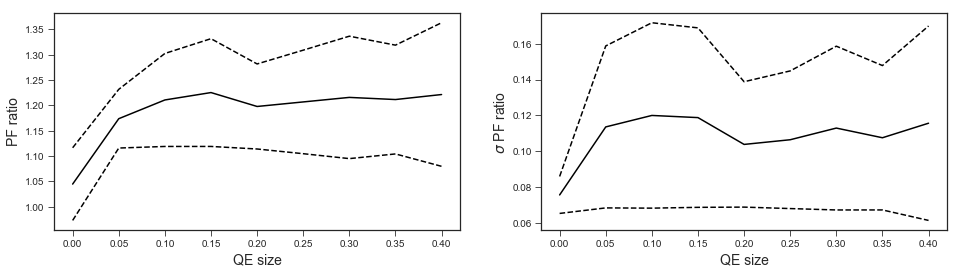

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages, 'k')
ax1.plot(qe_size, p_conf_uppers, 'k--')
ax1.plot(qe_size, p_conf_lowers, 'k--')

ax1.set_ylabel('PF ratio', fontsize='14')

ax2.plot(qe_size, av_stdev_qe_downswing, 'k')
ax2.plot(qe_size, ns_conf_uppers, 'k--')
ax2.plot(qe_size, ns_conf_lowers, 'k--')

ax2.set_ylabel('$\sigma$ PF ratio', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('BLR.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Next, can QT cool down asset price upswings?

QT boom

In [45]:
s_idx = 3
scenarios[s_idx]

'BOOMQT'

In [46]:
#qe_downswing_prices = [prices[0]]
qt_upswing_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    qt_upswing_prices.append((prices[e] / fundamentals[e])[:-1])

In [49]:
p_averages_qtu = []
p_conf_uppers_qtu = []
p_conf_lowers_qtu = []

av_stdev_qt_upswing = []
ns_conf_uppers_qtu = []
ns_conf_lowers_qtu = []
for idx, exp_pr in enumerate(qt_upswing_prices):
    p_averages_qtu.append(np.mean(qt_upswing_prices[idx].mean()))
    upper, lower = confidence_interval(qt_upswing_prices[idx].mean(), np.mean(qt_upswing_prices[idx].mean()))
    p_conf_uppers_qtu.append(upper)
    p_conf_lowers_qtu.append(lower)
    
    # detrend serie
    #stock_cycle, stock_trend = sm.tsa.filters.hpfilter(qt_upswing_prices[idx], lamb=100000000)
    
    #av_stdev_qt_upswing.append(np.mean(stock_cycle.std()))
    #upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    av_stdev_qt_upswing.append(np.mean(qt_upswing_prices[idx].std()) / np.mean(qt_upswing_prices[idx]).mean())
    upper, lower = confidence_interval(qt_upswing_prices[idx].std() / np.mean(qt_upswing_prices[idx]), 
                                       np.mean(qt_upswing_prices[idx].std()) / np.mean(qt_upswing_prices[idx].mean()))
    ns_conf_uppers_qtu.append(upper)
    ns_conf_lowers_qtu.append(lower)

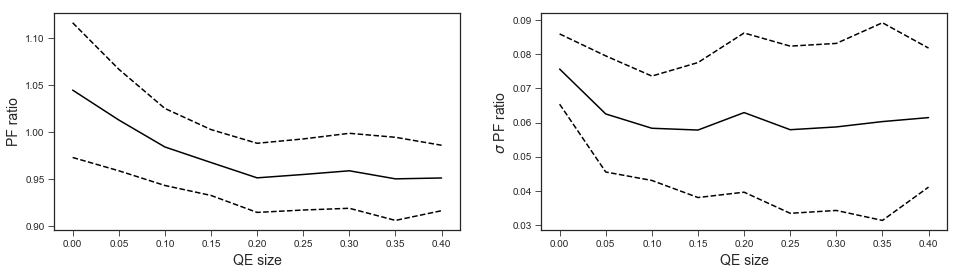

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages_qtu, 'k')
ax1.plot(qe_size, p_conf_uppers_qtu, 'k--')
ax1.plot(qe_size, p_conf_lowers_qtu, 'k--')

ax1.set_ylabel('PF ratio', fontsize='14')

ax2.plot(qe_size, av_stdev_qt_upswing, 'k')
ax2.plot(qe_size, ns_conf_uppers_qtu, 'k--')
ax2.plot(qe_size, ns_conf_lowers_qtu, 'k--')

ax2.set_ylabel('$\sigma$ PF ratio', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('SLR.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Then, Can a QE-QT mix stabilize the asset price cycle?  

In [52]:
s_idx = 1
scenarios[s_idx]

'BLR'

In [53]:
#qe_downswing_prices = [prices[0]]
blr_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    blr_prices.append((prices[e] / fundamentals[e])[:-1])

In [54]:
p_averages_blr = []
p_conf_uppers_blr = []
p_conf_lowers_blr = []

av_stdev_blr = []
ns_conf_uppers_blr = []
ns_conf_lowers_blr = []
for idx, exp_pr in enumerate(blr_prices):
    p_averages_blr.append(np.mean(blr_prices[idx].mean()))
    upper, lower = confidence_interval(blr_prices[idx].mean(), np.mean(blr_prices[idx].mean()))
    p_conf_uppers_blr.append(upper)
    p_conf_lowers_blr.append(lower)
    
    # detrend serie
    #stock_cycle, stock_trend = sm.tsa.filters.hpfilter(blr_prices[idx], lamb=100000000)
    
    #av_stdev_blr.append(np.mean(stock_cycle.std()))
    #upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    av_stdev_blr.append(np.mean(blr_prices[idx].std()) / np.mean(blr_prices[idx]).mean())
    upper, lower = confidence_interval(blr_prices[idx].std() / np.mean(blr_prices[idx]), 
                                       np.mean(blr_prices[idx].std()) / np.mean(blr_prices[idx].mean()))
    
    ns_conf_uppers_blr.append(upper)
    ns_conf_lowers_blr.append(lower)

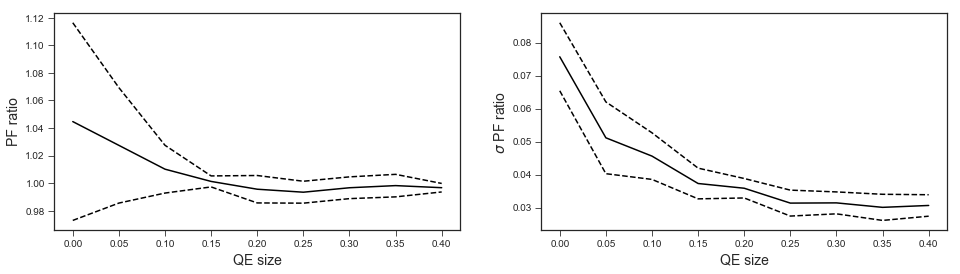

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages_blr, 'k')
ax1.plot(qe_size, p_conf_uppers_blr, 'k--')
ax1.plot(qe_size, p_conf_lowers_blr, 'k--')

ax1.set_ylabel('PF ratio', fontsize='14')

ax2.plot(qe_size, av_stdev_blr, 'k')
ax2.plot(qe_size, ns_conf_uppers_blr, 'k--')
ax2.plot(qe_size, ns_conf_lowers_blr, 'k--')

ax2.set_ylabel('$\sigma$ PF ratio', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('BSLR.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# What if the timing is wrong? 

## a QE in an upswing

In [27]:
s_idx = 4
scenarios[s_idx]

IndexError: list index out of range

In [28]:
#qe_downswing_prices = [prices[0]]
qe_upswing_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    qe_upswing_prices.append(prices[e])

IndexError: list index out of range

In [29]:
p_averages_qeu = []
p_conf_uppers_qeu = []
p_conf_lowers_qeu = []

av_stdev_qe_upswing = []
ns_conf_uppers_qeu = []
ns_conf_lowers_qeu = []
for idx, exp_pr in enumerate(qe_upswing_prices):
    p_averages_qeu.append(np.mean(qe_upswing_prices[idx].mean()))
    upper, lower = confidence_interval(qe_upswing_prices[idx].mean(), np.mean(qe_upswing_prices[idx].mean()))
    p_conf_uppers_qeu.append(upper)
    p_conf_lowers_qeu.append(lower)
    
    # detrend serie
    stock_cycle, stock_trend = sm.tsa.filters.hpfilter(qe_upswing_prices[idx], lamb=100000000)
    
    av_stdev_qe_upswing.append(np.mean(stock_cycle.std()))
    upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    ns_conf_uppers_qeu.append(upper)
    ns_conf_lowers_qeu.append(lower)

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

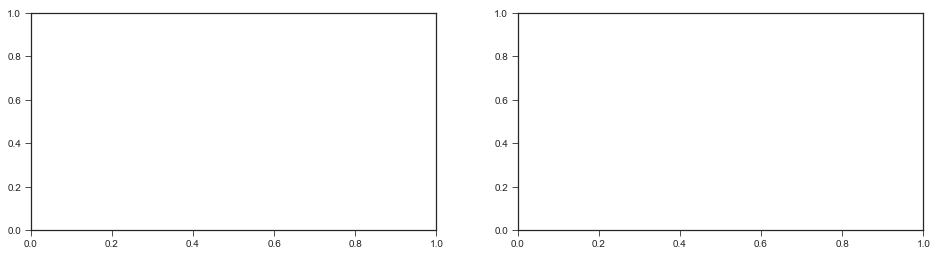

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages_qeu, 'k')
ax1.plot(qe_size, p_conf_uppers_qeu, 'k--')
ax1.plot(qe_size, p_conf_lowers_qeu, 'k--')

ax1.set_ylabel('Average price', fontsize='14')

ax2.plot(qe_size, av_stdev_qe_upswing, 'k')
ax2.plot(qe_size, ns_conf_uppers_qeu, 'k--')
ax2.plot(qe_size, ns_conf_lowers_qeu, 'k--')

ax2.set_ylabel('Stdev detrended price', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('QEboom.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## b QT in a downswing

In [57]:
s_idx = 3
scenarios[s_idx]

'BUSTQT'

In [58]:
#qe_downswing_prices = [prices[0]]
qt_downswing_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    qt_downswing_prices.append(prices[e])

In [59]:
p_averages_qtd = []
p_conf_uppers_qtd = []
p_conf_lowers_qtd = []

av_stdev_qtd = []
ns_conf_uppers_qtd = []
ns_conf_lowers_qtd = []
for idx, exp_pr in enumerate(qt_downswing_prices):
    p_averages_qtd.append(np.mean(qt_downswing_prices[idx].mean()))
    upper, lower = confidence_interval(qt_downswing_prices[idx].mean(), np.mean(qt_downswing_prices[idx].mean()))
    p_conf_uppers_qtd.append(upper)
    p_conf_lowers_qtd.append(lower)
    
    # detrend serie
    stock_cycle, stock_trend = sm.tsa.filters.hpfilter(qt_downswing_prices[idx], lamb=100000000)
    
    av_stdev_qtd.append(np.mean(stock_cycle.std()))
    upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    ns_conf_uppers_qtd.append(upper)
    ns_conf_lowers_qtd.append(lower)

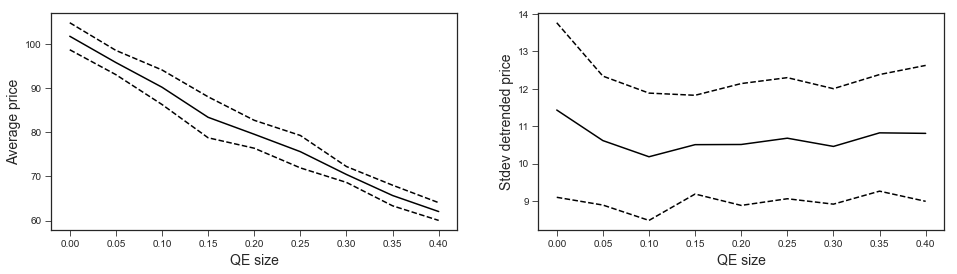

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages_qtd, 'k')
ax1.plot(qe_size, p_conf_uppers_qtd, 'k--')
ax1.plot(qe_size, p_conf_lowers_qtd, 'k--')

ax1.set_ylabel('Average price', fontsize='14')

ax2.plot(qe_size, av_stdev_qtd, 'k')
ax2.plot(qe_size, ns_conf_uppers_qtd, 'k--')
ax2.plot(qe_size, ns_conf_lowers_qtd, 'k--')

ax2.set_ylabel('Stdev detrended price', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('QTbust.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Stupid policy graph summary

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

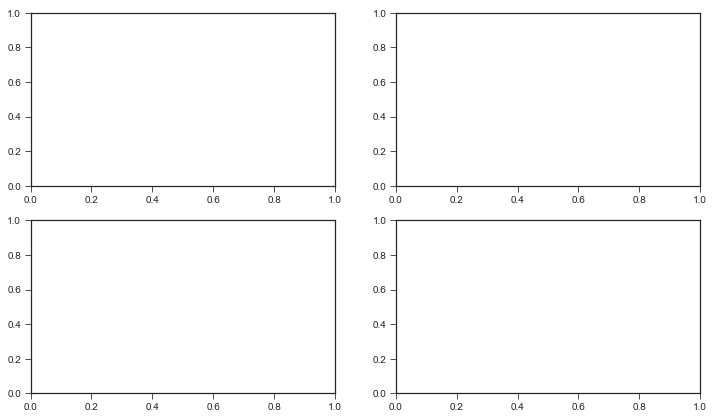

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[12,7])

ax1.plot(qe_size, p_averages_qeu, 'k')
ax1.plot(qe_size, p_conf_uppers_qeu, 'k--')
ax1.plot(qe_size, p_conf_lowers_qeu, 'k--')

ax1.set_ylabel('Average price', fontsize='14')
ax1.set_title('QE in upswing', fontsize='14')

ax2.plot(qe_size, p_averages_qtd, 'k')
ax2.plot(qe_size, p_conf_uppers_qtd, 'k--')
ax2.plot(qe_size, p_conf_lowers_qtd, 'k--')
ax2.set_title('QT in downswing', fontsize='14')
ax2.set_ylabel('Average price', fontsize='14')

ax3.plot(qe_size, av_stdev_qe_upswing, 'k')
ax3.plot(qe_size, ns_conf_uppers_qeu, 'k--')
ax3.plot(qe_size, ns_conf_lowers_qeu, 'k--')

ax3.set_ylabel('Stdev detrended price', fontsize='14')

ax4.plot(qe_size, av_stdev_qtd, 'k')
ax4.plot(qe_size, ns_conf_uppers_qtd, 'k--')
ax4.plot(qe_size, ns_conf_lowers_qtd, 'k--')

ax4.set_ylabel('Stdev detrended price', fontsize='14')


for ax in (ax3, ax4):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('QEboomQTbust.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)